In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import nlopt
import fem2d as fe
import tikzplotlib as tikzplt 

Example : Optimal distribution of two materials for volume minimization of the first material subject to a thermal compliance constraint. The two materials have different diffusive properties for heat.

Beginning mesh generation...
Mesh generated!


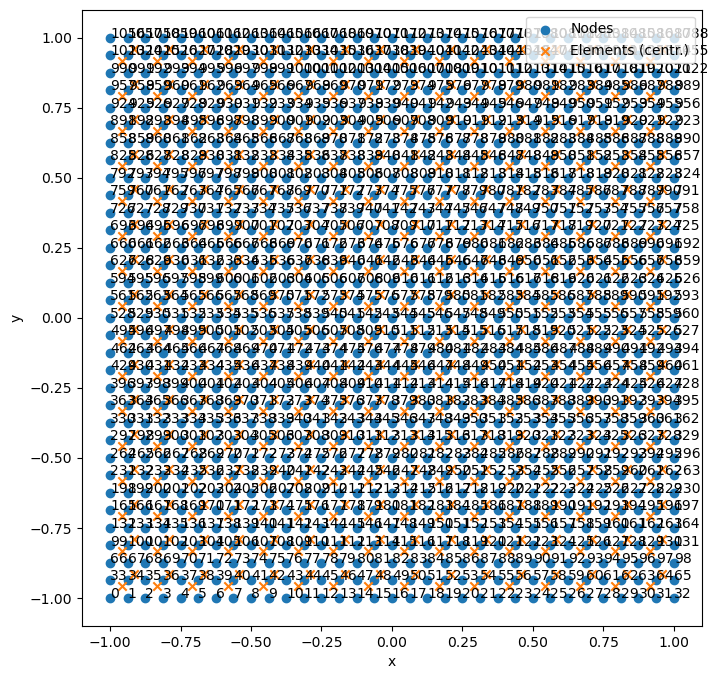

In [2]:
nx = 16
ny = 16
mesh = fe.Mesh(nx, ny,-1,-1,2,2)
nelem = mesh.getNelems()
nddl = mesh.getNddlsScal()
refElem = fe.RefElement(mesh)
mesh.displayMesh()

Initialize the finite element problem

In [3]:
# Boundary conditions
dirichletnodes = np.sort(list(range(0,32))+list(range(1056,1088))+list(range(33,1023,33))+list(range(65,1055,33)))
dirichletddls = np.sort(mesh.getDDLnumerScal()[dirichletnodes].flatten())
ess = np.zeros_like(dirichletddls)

# Declare elasticity problem
heat_solver = fe.Problem(mesh,1)
heat_solver.setDirichletBC(dirichletddls,ess)
mDivAGradT = fe.DiffusionTerm(refElem, mesh.getNelems())
tensorfield = [np.eye(2) for k in range(nelem)]
mDivAGradT.setParams(tensorfield)
heat_solver.addTerm(mDivAGradT)
f = lambda x : 56*(1-np.abs(x[0])-np.abs(x[1]))**6
heatsource = fe.SourceTermScal(refElem)
heatsource.setParams(f)
heat_solver.addTermRHS(heatsource)

Initialize optimization problem

In [4]:
d = nelem
# Physical Parameters
k1 = 2
k2 = 1
volfrac = 0.6
vol = 4
#Emax = 1.35

# Problem to compute matrix of gradient of basis functions
probleme_grad = fe.Problem(mesh,1)
gradugradu = fe.DiffusionTerm(refElem, mesh.getNelems())
csttensorfield = [np.eye(2) for k in range(d)]
gradugradu.setParams(csttensorfield)
probleme_grad.addTerm(gradugradu)
probleme_grad.solve(OnlyAssembly=True)
GradMatrix = probleme_grad.getCurrentElemMat()

# Declare constraint + objective
def c(x, grad):
    if np.shape(grad)[0] != 0:
        grad[:] = (0.5*(2/ny)**2)*np.ones(d)
    print(f"Vol = {np.dot((0.5*(2/ny)**2)*np.ones(d),x)}")
    return np.dot((0.5*(2/ny)**2)*np.ones(d),x) - volfrac*vol

def J(x, grad):
    tensorfield = [((k1-k2)*x[k] + k2)*np.eye(2) for k in range(d)]
    mDivAGradT.setParams(tensorfield)
    U=heat_solver.solve()
    
    if np.shape(grad)[0] != 0:
        for k in range(d):
            grad[k] = (-0.5*(k1-k2)*GradMatrix[:,nddl*k:nddl*(k+1)]).dot(U).dot(U)
    j = 0.5*heat_solver.getCurrentMatrix().dot(U).dot(U)
    print(f"J = {j}")
    return j


# Declare optimization solver (MMA from NLopt)
optim_solver = nlopt.opt(nlopt.LD_MMA, d)
optim_solver.set_min_objective(J)
optim_solver.set_lower_bounds(np.zeros(d))
optim_solver.set_upper_bounds(np.ones(d))
optim_solver.add_inequality_constraint(c)
optim_solver.set_param("verbosity",2)
#solver.set_stopval(1e25)
optim_solver.set_maxeval(100)
optim_solver.set_xtol_abs(1e-10)



Beginning assembly...
Assembly done!


Optimize using NLOpt

In [ ]:
sol = optim_solver.optimize(np.ones(d))
result = optim_solver.last_optimize_result(); # 1 = success, 2 = values over the max value, 4 = xtol conv
print(f"Exit code = {result}")
print(f"Neval J = {optim_solver.get_numevals()}")

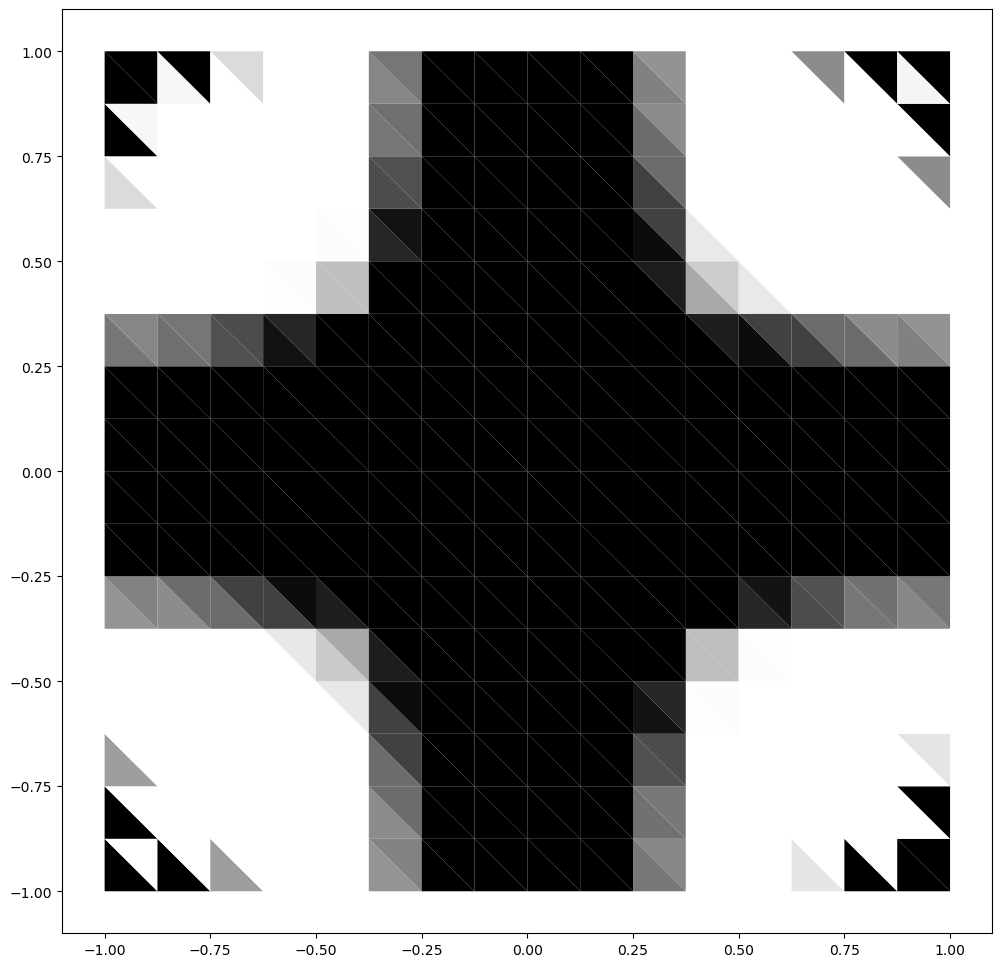

In [7]:
mesh.displayDiscontinuousByElementField(1-sol)

In [10]:
c(sol,np.array([]))

Vol = 2.4000000908855696


9.088556973679829e-08

In [11]:
(J(sol,np.array([]))/1.35)*100


Beginning assembly...
Assembly done!
Beginning solving...
Solved!
J = 1.2041590614664475


89.19696751603314